In [1]:
import skimage as sk
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import ball
from skimage.segmentation import watershed
from skimage.filters import rank
from scipy import ndimage as ndi
from copy import copy
import tifffile as tiff


In [2]:
def normalize_image(im, mult_factor = 1):
    '''
    Normalize image 0-1 and multiply by any factor
    '''
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

def reverse_values(im):
    '''
    Reverse values of the image
    '''
    rev_im = im.max()-im
    return rev_im

In [3]:
image = sk.io.imread('./../ppujol/cellstosegment/32_2/image_used.tif')

Initial image shape: (240, 240, 240), working image shape: (240, 240, 240)


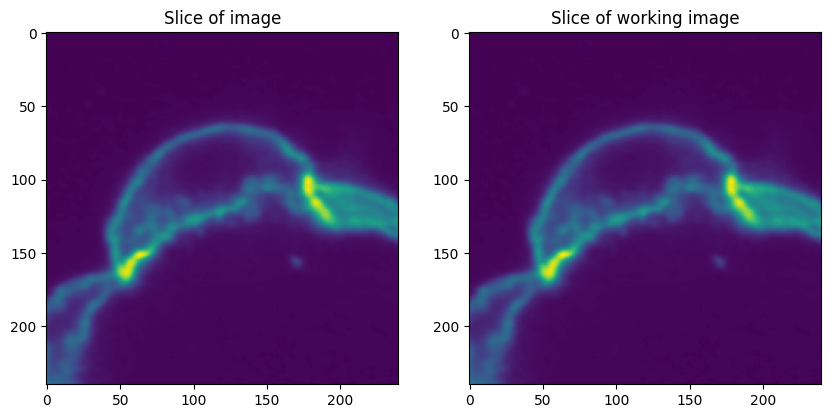

In [5]:
z, y, x = 120, 120, 120
delta = 120
division = 1
cell = image[z-int(delta/division):z+int(delta/division), y-delta:y+delta, x-delta:x+delta]
plt.figure(figsize=(10,20))
plt.subplot(121)
plt.title("Slice of image")
plt.imshow(image[int(delta/division)])
plt.subplot(122)
plt.title("Slice of working image")
plt.imshow(cell[int(delta/division)])

print(f"Initial image shape: {image.shape}, working image shape: {cell.shape}")

In [7]:
def watershed_process_inner_cell(cell, plots=False, segmentation=True, y='', reduce=''):
    '''
    Segmentation function using the image as it is, not the gradient.
    - 
    '''
    if y == '':
        y = int(delta/division)
    
    cell = normalize_image(cell, 255).astype(np.uint8)
    cell_border = copy(cell)

    denoised = rank.median(cell_border, ball(2)) # It was ball2

    markers = rank.gradient(denoised, ball(5)) < 10 # It was ball5 and <10
    markers = ndi.label(markers)[0]

    labels = watershed(denoised, markers) # Before it was gradient, markers

    seed_point = (int(delta/division),delta,delta)

    labels[labels != labels[seed_point]] = 0

    labels = sk.morphology.binary_closing(labels, footprint=sk.morphology.ball(5))
    labels = sk.morphology.binary_opening(labels, footprint=sk.morphology.ball(2))

    maskImage = labels*cell_border

    edt = ndi.distance_transform_edt(maskImage)

    if reduce != '':
        edt = sk.morphology.erosion(edt, footprint=ball(reduce))

    if segmentation == False:
        edt = reverse_values(edt)*cell_border
        reduced_edt = sk.morphology.erosion(edt, footprint=ball(3))

    else:
        edt_border = reverse_values(edt*cell_border)


    if plots == True:

        plt.figure(figsize=(20,8))

        plt.subplot(151)
        plt.title("Median Filter")
        plt.imshow(denoised[y])

        plt.subplot(152)
        plt.title("Labels")
        plt.imshow(labels[y])

        plt.subplot(153)
        plt.title("labels*cell_border")
        plt.imshow(maskImage[y])

        plt.subplot(154)
        plt.title("Euclidian distance transform")
        plt.imshow(edt[y])

        plt.subplot(155)
        plt.title("Edt border")
        plt.imshow(reduced_edt[y])

    return reduced_edt, labels, edt

In [8]:
edt_border, label, edt = watershed_process_inner_cell(cell=cell, plots=True, segmentation=False)

KeyboardInterrupt: 

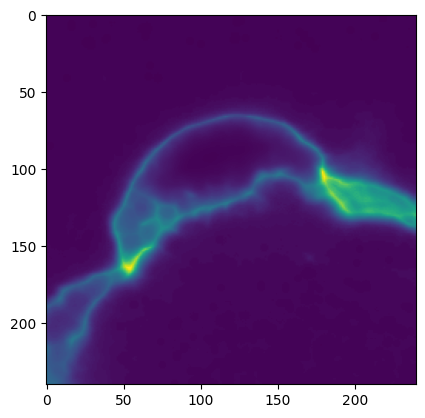

In [ ]:
plt.imshow(edt_border[120])

In [9]:
def high_borders(cell):
    cell = normalize_image(cell, 255).astype(np.uint8)
    cell_border = copy(cell)

    denoised = rank.median(cell_border, ball(2)) # It was ball2

    # markers = rank.gradient(denoised, ball(5)) < 10 # It was ball5 and <10
    # markers = ndi.label(markers)[0]

    # labels = watershed(denoised, markers) # Before it was gradient, markers

    # seed_point = (int(delta/division),delta,delta)

    # labels[labels != labels[seed_point]] = 0

    # labels = sk.morphology.binary_closing(labels, footprint=sk.morphology.ball(5))
    # labels = sk.morphology.binary_opening(labels, footprint=sk.morphology.ball(2))

    # maskImage = labels*cell_border

    # edt = ndi.distance_transform_edt(maskImage)

    # edt = reverse_values(edt)*cell_border
    # reduced_edt = sk.morphology.erosion(edt, footprint=ball(3))

    edt = ndi.distance_transform_edt(denoised)
    edt = reverse_values(edt)*cell_border

    reduced_edt = sk.morphology.erosion(edt, footprint=ball(3))


    return reduced_edt

In [10]:
cell_borders = high_borders(cell=image)

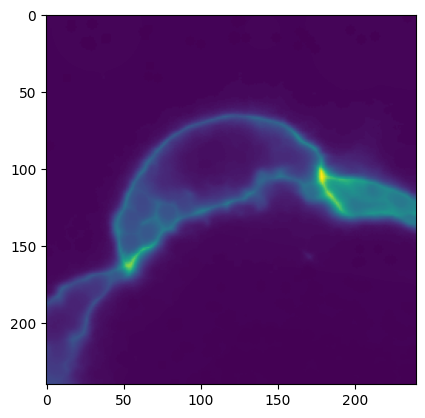

In [11]:
slice = 120
plt.imshow(cell_borders[slice])

In [15]:

bordere_write = './../ppujol/cellstosegment/32_2/border_image_DENOISE_all.tif'

tiff.imwrite(bordere_write, normalize_image(cell_borders, 65535).astype(np.uint16), imagej=True)

In [1]:
def high_borders_2(cell):
    cell = normalize_image(cell, 255).astype(np.uint8)
    cell_border = copy(cell)

    denoised = rank.median(cell_border, ball(2)) # It was ball2

    edt = ndi.distance_transform_edt(denoised)
    edt = reverse_values(edt)*cell_border

    reduced_edt = sk.morphology.erosion(edt, footprint=ball(3))


    return reduced_edt

In [6]:
full_dome = sk.io.imread('./../ppujol/zmap/62_denoised time 3.tif')
full_dome_edt = high_borders_2(full_dome)
tiff.imwrite('./../ppujol/62_denoised_edt_time_3.tif', normalize_image(full_dome_edt, 65535).astype(np.uint16), imagej=True)